# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.59KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

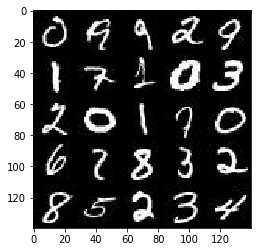

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

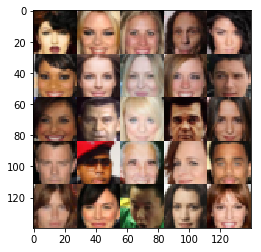

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels ), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [42]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x 3
        alpha = 0.1
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu3, 512, 3, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        flat = tf.reshape(relu4, (-1, 7 * 7 * 512))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [43]:
def generator(z, out_channel_dim,is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3 ,strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3 ,strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3 ,strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3 ,strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [44]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [45]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt= model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2 
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode)
                    
    print("Finish training")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.5670... Generator Loss: 0.4125
Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 5.8088
Epoch 1/2... Discriminator Loss: 2.6611... Generator Loss: 0.3710
Epoch 1/2... Discriminator Loss: 1.7154... Generator Loss: 0.5251
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 5.4623
Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 1.7478
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 2.8445
Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 3.6692
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 1.4849
Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 0.9405


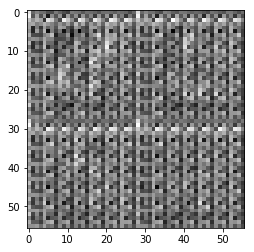

Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 2.5537
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 2.4862
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.5022
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 0.7280... Generator Loss: 2.1738
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.0319
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 2.0461
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.6159


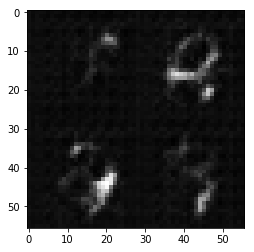

Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.7653
Epoch 1/2... Discriminator Loss: 0.7744... Generator Loss: 1.6158
Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 1.9795
Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 0.9345
Epoch 1/2... Discriminator Loss: 2.5948... Generator Loss: 0.2506
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 2.5226
Epoch 1/2... Discriminator Loss: 0.8180... Generator Loss: 1.2042
Epoch 1/2... Discriminator Loss: 3.0264... Generator Loss: 0.1181
Epoch 1/2... Discriminator Loss: 1.5977... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.5423


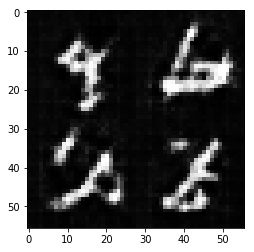

Epoch 1/2... Discriminator Loss: 1.7227... Generator Loss: 0.3871
Epoch 1/2... Discriminator Loss: 0.8242... Generator Loss: 1.3010
Epoch 1/2... Discriminator Loss: 0.8275... Generator Loss: 1.7792
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 1.6397... Generator Loss: 0.4820
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 2.5782
Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 0.9587... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 1.5567... Generator Loss: 2.4239
Epoch 1/2... Discriminator Loss: 1.5680... Generator Loss: 0.6865


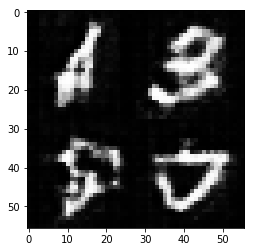

Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 2.2070
Epoch 1/2... Discriminator Loss: 1.7490... Generator Loss: 3.2341
Epoch 1/2... Discriminator Loss: 0.9146... Generator Loss: 1.9964
Epoch 1/2... Discriminator Loss: 2.8071... Generator Loss: 4.3768
Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 0.7122
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 1.5106
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 1.7368
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.1692
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 2.0585
Epoch 2/2... Discriminator Loss: 4.4688... Generator Loss: 4.9588


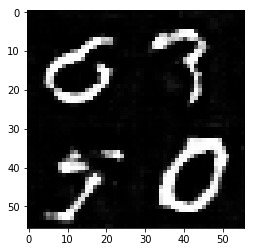

Epoch 2/2... Discriminator Loss: 2.0713... Generator Loss: 0.2946
Epoch 2/2... Discriminator Loss: 1.5370... Generator Loss: 0.5216
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.5562... Generator Loss: 0.4826
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 1.7146... Generator Loss: 0.4087
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 2.0963
Epoch 2/2... Discriminator Loss: 1.6731... Generator Loss: 0.4216
Epoch 2/2... Discriminator Loss: 1.6752... Generator Loss: 0.4001
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.7585


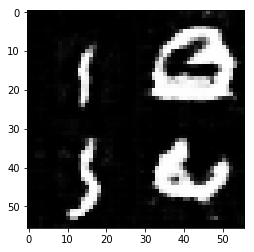

Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 3.2529
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 1.1761
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 2.5452
Epoch 2/2... Discriminator Loss: 1.7447... Generator Loss: 0.4614
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 1.7437
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 2.7100
Epoch 2/2... Discriminator Loss: 2.1874... Generator Loss: 0.3228
Epoch 2/2... Discriminator Loss: 1.5370... Generator Loss: 0.4851
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 2.0052


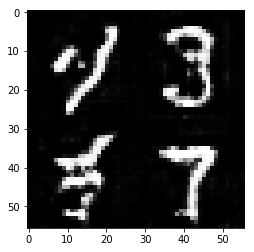

Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.3532
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 2.4473
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 2.4902
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 1.4540... Generator Loss: 3.4679
Epoch 2/2... Discriminator Loss: 2.2756... Generator Loss: 0.2780
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 1.2197
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.8667
Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.7418


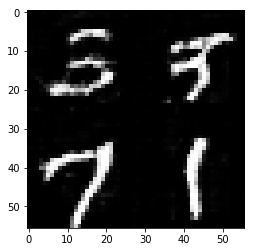

Epoch 2/2... Discriminator Loss: 1.2716... Generator Loss: 0.7460
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 2.0178
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 0.9753
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.6070
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 2.3068
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 1.3781
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 1.2783
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 0.9749
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 0.8777
Epoch 2/2... Discriminator Loss: 1.1916... Generator Loss: 0.8338


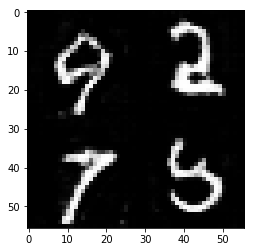

Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 1.3306
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.6625
Epoch 2/2... Discriminator Loss: 1.6153... Generator Loss: 0.6769
Finish training


In [50]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 8.6871
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 15.7398
Epoch 1/1... Discriminator Loss: 2.8263... Generator Loss: 0.2851
Epoch 1/1... Discriminator Loss: 1.6981... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.9604... Generator Loss: 4.4131
Epoch 1/1... Discriminator Loss: 2.1643... Generator Loss: 0.3025
Epoch 1/1... Discriminator Loss: 2.4849... Generator Loss: 0.2103


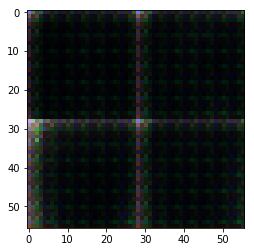

Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.2785
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.8656
Epoch 1/1... Discriminator Loss: 2.9833... Generator Loss: 0.1235
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.1685
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 2.1460... Generator Loss: 0.3177
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.4075


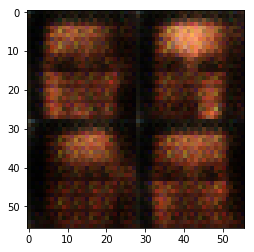

Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 2.6052
Epoch 1/1... Discriminator Loss: 2.0801... Generator Loss: 3.9197
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 2.4999
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 2.1566
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.6683
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 1.7246
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 1.5070


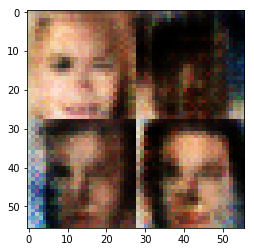

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.6398
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.6237... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 2.3657
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6340


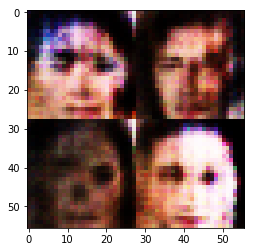

Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.1611
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.6199
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.7166
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 1.0475


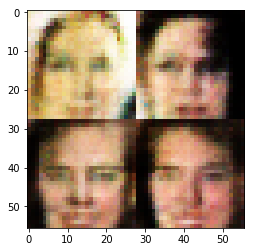

Epoch 1/1... Discriminator Loss: 2.3647... Generator Loss: 3.9816
Epoch 1/1... Discriminator Loss: 1.7586... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.7186
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.6864... Generator Loss: 2.5932


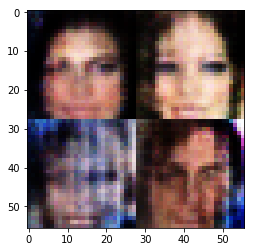

Epoch 1/1... Discriminator Loss: 1.9789... Generator Loss: 2.8634
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.5313
Epoch 1/1... Discriminator Loss: 1.6824... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.4156
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.5340


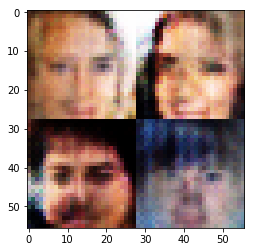

Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 0.4477
Epoch 1/1... Discriminator Loss: 1.9857... Generator Loss: 2.4600
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.6676... Generator Loss: 2.6519


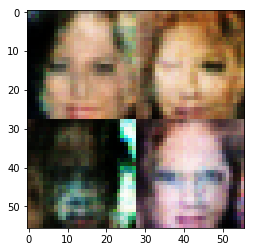

Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.2530
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 1.7003
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 2.3015


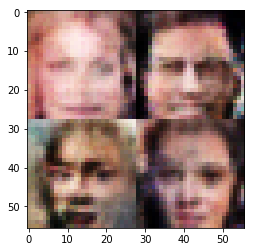

Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.8449... Generator Loss: 0.3400
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.2564
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.0345


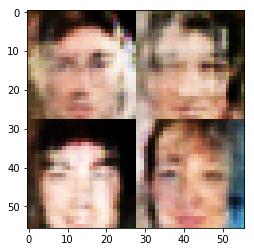

Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 1.9765
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 2.0839
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.3409
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.5061


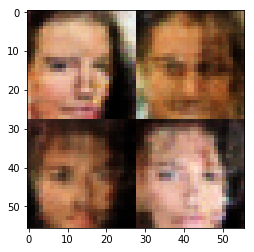

Epoch 1/1... Discriminator Loss: 2.4393... Generator Loss: 3.5009
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.6484
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.6511
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 1.5416
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.7233... Generator Loss: 2.1256


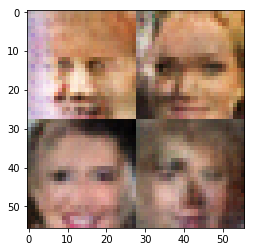

Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.4218
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.2719
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 2.2012... Generator Loss: 0.2531
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.3613
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.9885


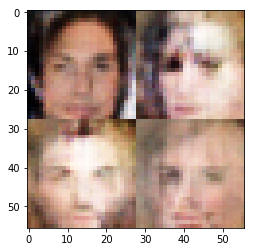

Epoch 1/1... Discriminator Loss: 1.8105... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 2.4704
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.3274
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.7194


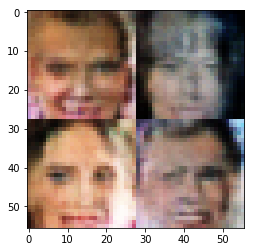

Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.6390
Epoch 1/1... Discriminator Loss: 2.7530... Generator Loss: 3.1758
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.2596


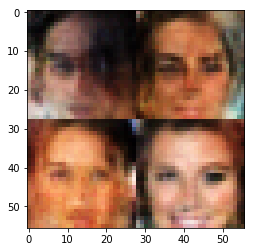

Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.2422
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.2542
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.5478


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.